In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.callbacks import BasePredictionWriter

import shap
import shap.explainers
shap.initjs()


In [62]:
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    # Split the session into hourly intervals
    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate hourly intervals
        hourly_intervals = pd.date_range(
            start=start.floor('h'), end=end.ceil('h'), freq='h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    # Create a new dataframe from the hourly intervals
    hourly_df = pd.DataFrame(hourly_rows)

    # Aggregate the hourly intervals
    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(
        hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - \
        pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='h')

    # Reindex the hourly data to include all hours in the range
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    # Return the hourly data
    return hourly_df


def add_features(hourly_df):
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day']
                            >= 6) & (hourly_df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  hourly_df['IsHoliday'] = hourly_df.index.map(
      lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(
      2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(
      2 * np.pi * hourly_df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  # 0 = Spring, 1 = Summer, 2 = Autumn, 3 = Winter
  month_to_season = {1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 1,
                     7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 3}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  # Lag features
  # 1h
  hourly_df['Energy_Consumption_1h'] = hourly_df['Energy_Consumption'].shift(1)

  # 6h
  hourly_df['Energy_Consumption_6h'] = hourly_df['Energy_Consumption'].shift(6)

  # 12h
  hourly_df['Energy_Consumption_12h'] = hourly_df['Energy_Consumption'].shift(
      12)

  # 24h
  hourly_df['Energy_Consumption_24h'] = hourly_df['Energy_Consumption'].shift(
      24)

  # 1 week
  hourly_df['Energy_Consumption_1w'] = hourly_df['Energy_Consumption'].shift(
      24*7)

  # Rolling average
  # 24h
  hourly_df['Energy_Consumption_rolling'] = hourly_df['Energy_Consumption'].rolling(
      window=24).mean()

  return hourly_df


def filter_data(start_date, end_date, data):
    ####################### FILTER DATASET  #######################
    data = data[(data.index >= start_date) & (data.index <= end_date)].copy()
    # print(data.head())

    return data


# Used for SHAP values/plotting
feature_names = ['Energy_Consumption', 'Session_Count', 'Day_of_Week', 'Hour_of_Day',
                 'Month_of_Year', 'Year', 'Day/Night', 'IsHoliday', 'Weekend', 'HourSin',
                 'HourCos', 'DayOfWeekSin', 'DayOfWeekCos', 'MonthOfYearSin',
                 'MonthOfYearCos', 'Energy_Consumption_1h', 'Energy_Consumption_6h',
                 'Energy_Consumption_12h', 'Energy_Consumption_24h',
                 'Energy_Consumption_1w', 'Energy_Consumption_rolling', 'Season_0',
                 'Season_1', 'Season_2', 'Season_3', 'Season_4']

In [63]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return len(self.X) - self.seq_len

  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [64]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):

    # Load and preprocess the data
    data = pd.read_csv(self.data_dir)
    data = convert_to_hourly(data)
    data = add_features(data)

    start_date = pd.to_datetime('2021-11-30')
    end_date = pd.to_datetime('2023-11-30')

    # One hot encoding for seasons
    data = pd.get_dummies(data, columns=['Season'])

    # Filter the data
    df = filter_data(start_date, end_date, data)

    # remove nan values
    df = df.dropna()

    X = df.copy()
    y = X['Energy_Consumption'].shift(-1).ffill()

    # Split the data into training, validation, and test sets
    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)
    
    # Normalize the data
    preprocessing = self.scaler
    preprocessing.fit(self.X_train) # should only fit to training data

        
    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = self.y_train.values.reshape((-1, 1))
      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = self.y_val.values.reshape((-1, 1))

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = self.y_test.values.reshape((-1, 1))

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

In [65]:
class LSTM(L.LightningModule):
  def __init__(self, input_size, hidden_size, num_layers, criterion, dropout, learning_rate):
    super().__init__()
    self.save_hyperparameters(ignore=['criterion'])
    self.dropout = dropout
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

In [66]:
class GRU(L.LightningModule):
  def __init__(self, input_size, hidden_size, num_layers, criterion, dropout, learning_rate):
    super().__init__()
    self.save_hyperparameters(ignore=['criterion'])
    self.dropout = dropout
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y)
    self.log("train_loss", train_loss, on_step=True,
             on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True,
             on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True,
             on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

In [67]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval):
    super().__init__(write_interval)
    self.output_dir = output_dir

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))
    # torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt")) # for batch indices if needed

In [68]:
params = dict(
  input_size = 26,
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(),
  max_epochs = 50,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 1, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  num_workers = 0, # only work in .py for me
  is_persistent = False, # only work in .py for me
  scaler = MinMaxScaler()
)

In [69]:
model = GRU(input_size=params['input_size'], hidden_size=params['hidden_size'], num_layers=params['num_layers'],criterion=params['criterion'], dropout=params['dropout'], learning_rate=params['learning_rate'])
colmod = ColoradoDataModule(data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv',scaler=params['scaler'], seq_len=params['seq_len'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
pred_writer = CustomWriter(output_dir="Models", write_interval="epoch")

## Runs

Standard Run

In [70]:
trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(monitor="val_loss", mode="min"), pred_writer], default_root_dir='Models')
trainer.fit(model, colmod)
trainer.test(model, colmod)
trainer.predict(model, colmod, return_predictions=False)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | gru       | GRU     | 38.4 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
38.5 K    Trainable params
0         Non-trainable params
38.5 K    Total params
0.154     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  9.28it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1313/1313 [00:15<00:00, 82.56it/s, v_num=138, train_loss_step=22.70, val_loss_step=24.00, val_loss_epoch=175.0, train_loss_epoch=34.20] 


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 437/437 [00:02<00:00, 203.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         438.0030212402344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 437/437 [00:01<00:00, 268.90it/s]


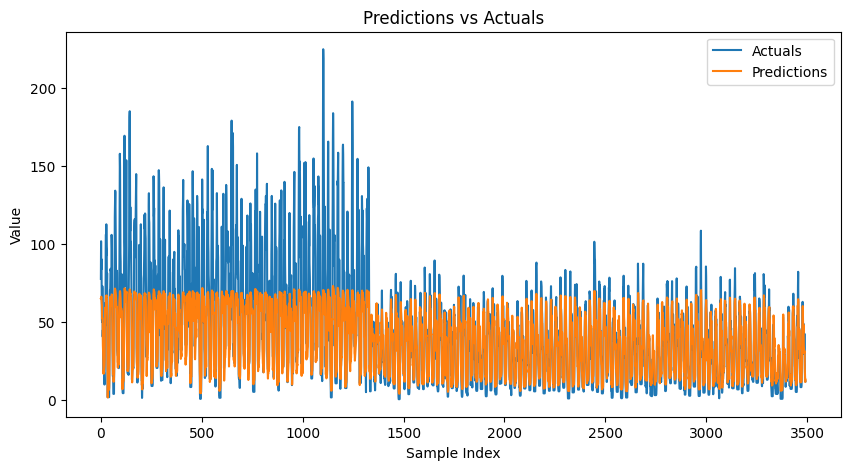

In [71]:
predictions = torch.load('Models/predictions_0.pt')

actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

# Flatten the predictions and actuals
predictions_flat = [item.item() for sublist in predictions for item in sublist]
actuals_flat = [item for sublist in actuals for item in sublist]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(actuals_flat, label='Actuals')
plt.plot(predictions_flat, label='Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()

## SHAP

### Feature Importance Using KernelExplainer 

 62%|██████▎   | 5/8 [00:00<00:00,  9.91it/s]/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.095e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
100%|██████████| 8/8 [00:00<00:00, 10.03it/s]
/var/folders/9x/yl6kp0_j23s302pc3z00dpjh0000gn/T/ipykernel_26305/2234091785.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_aggregated, feature_names,


SHAP values shape: (8, 26)


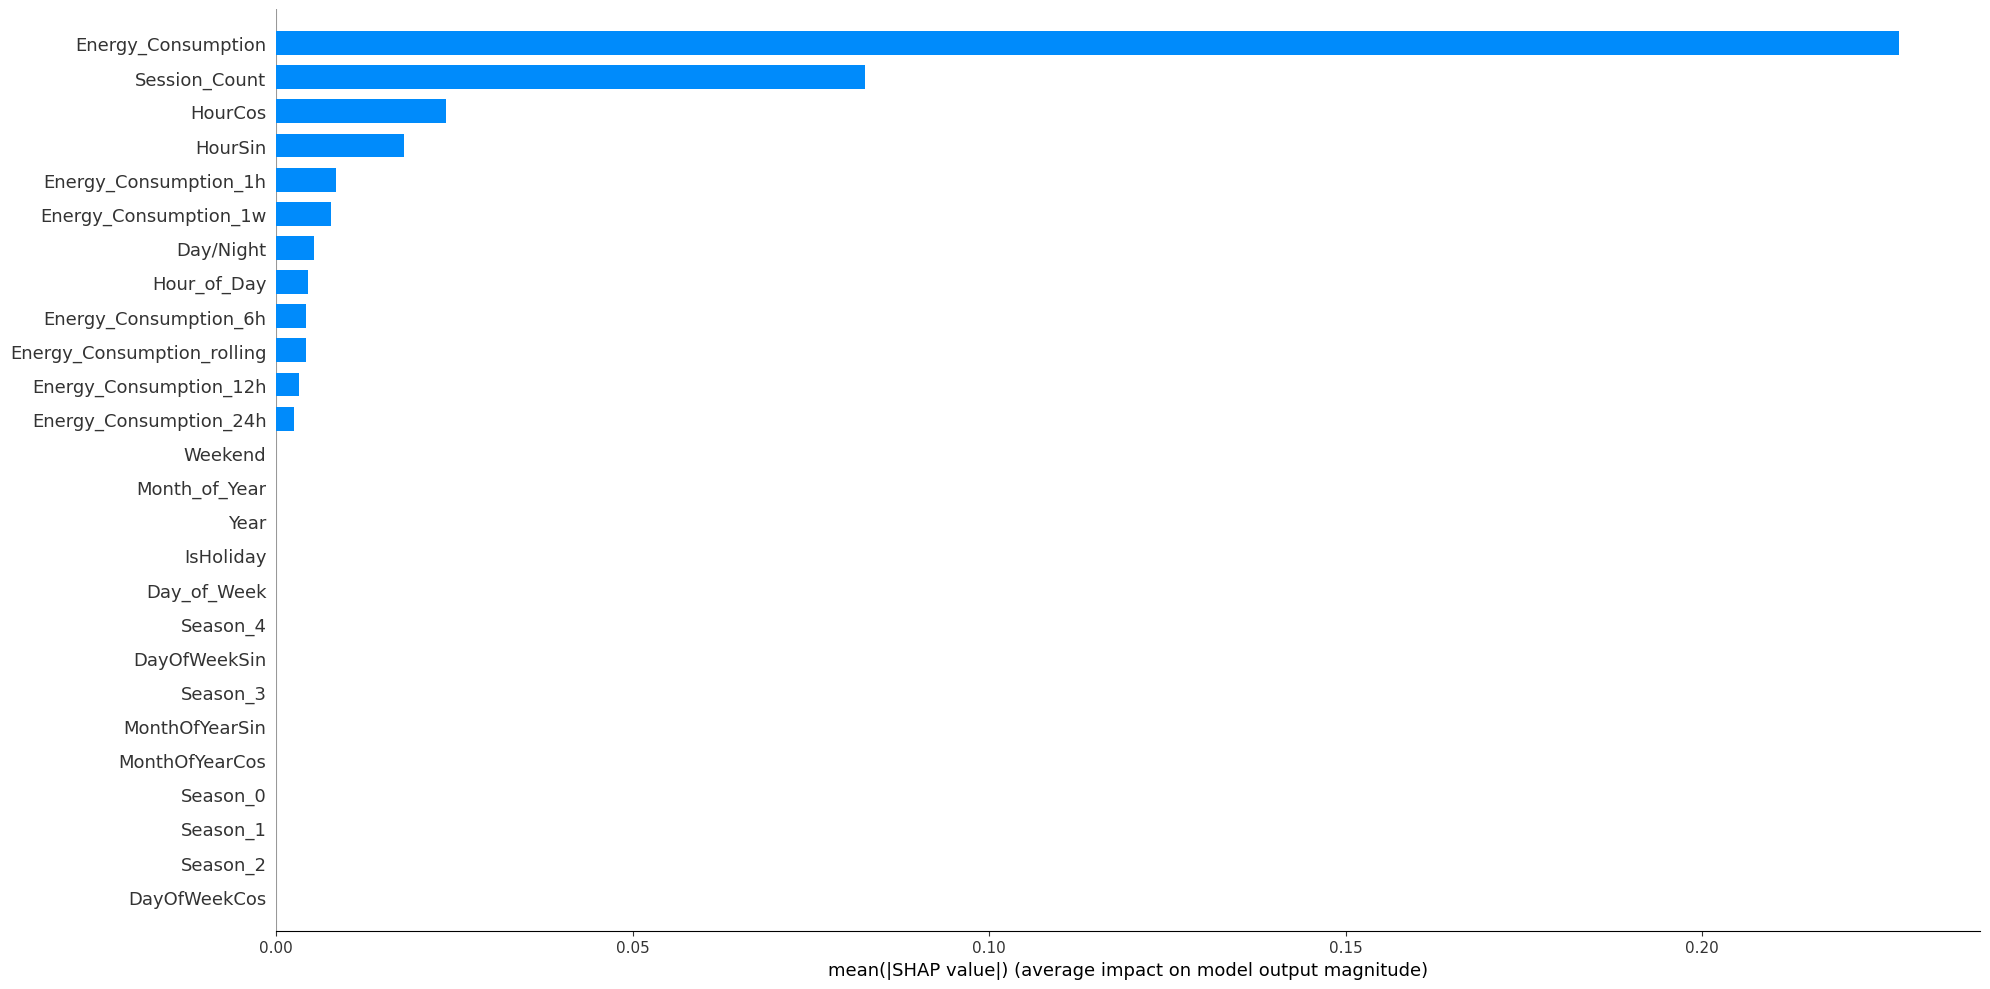

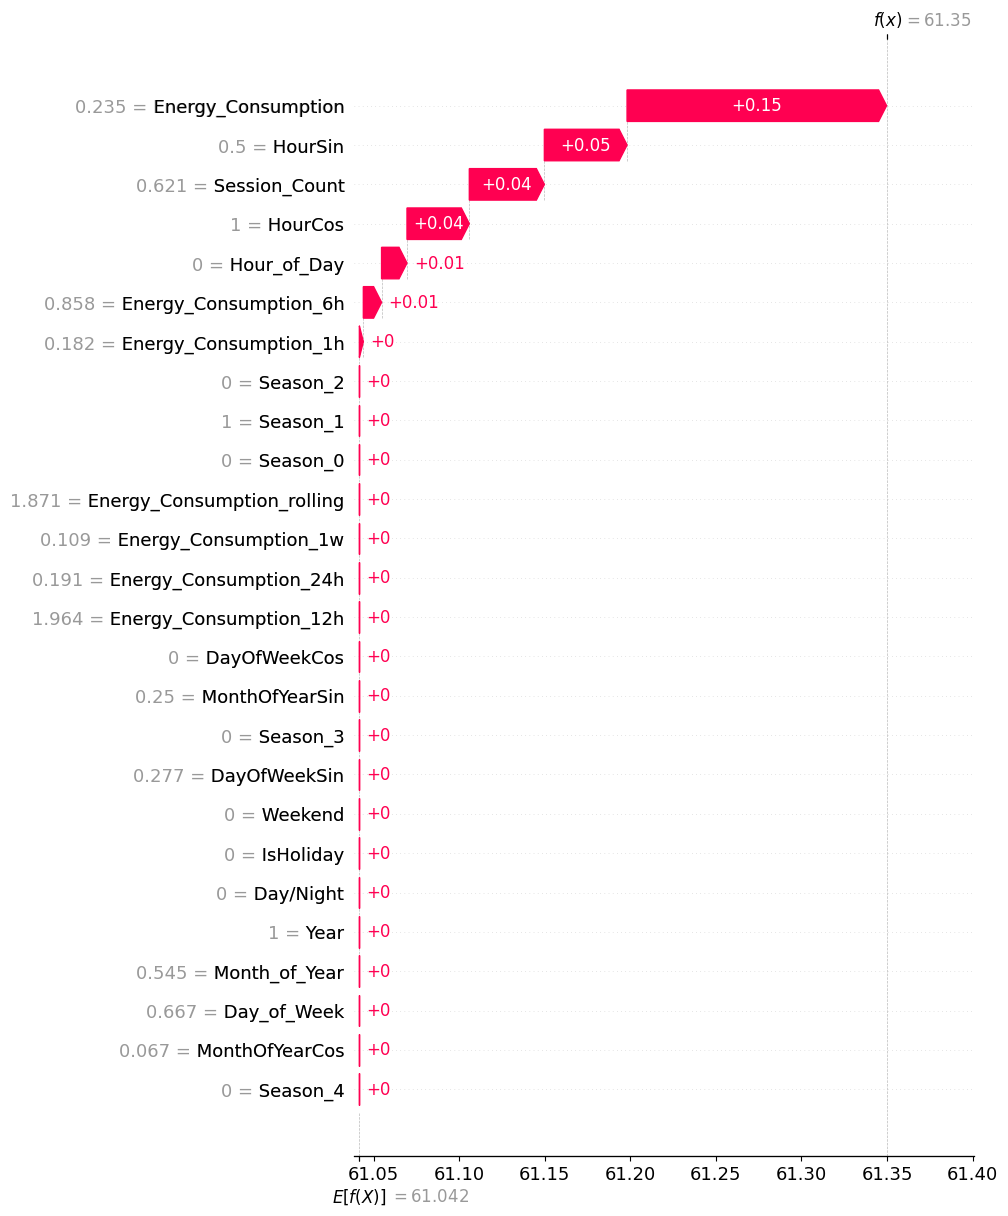

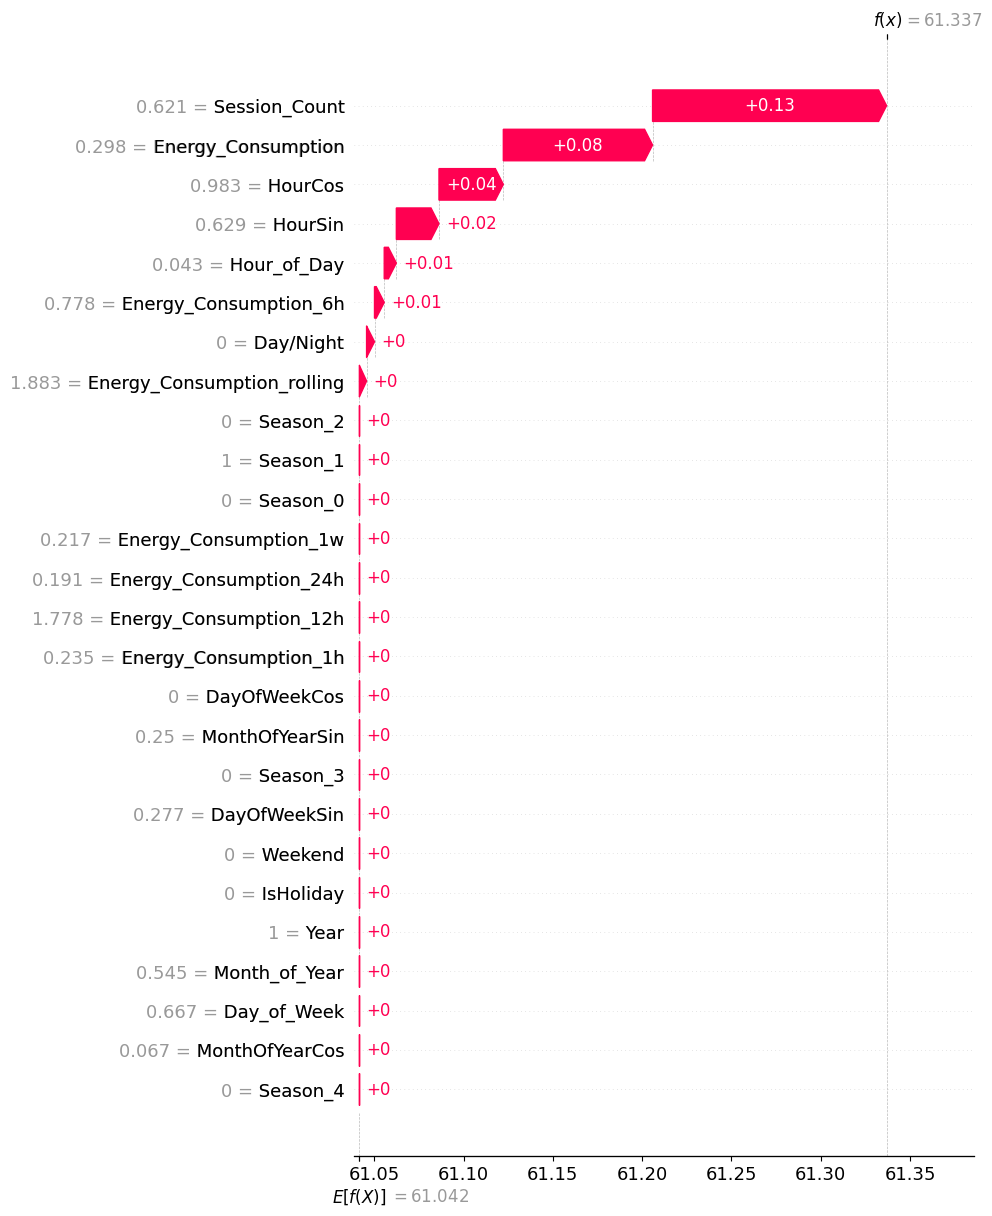

In [72]:
def compute_shap_values(model, dataloader, feature_names, nsamples=100, agg_func=np.mean):
  ## Compute SHAP values ##
  X, _ = next(iter(dataloader))
  batch_size, seq_len, input_size = X.shape

  # To use KernalExplainer, we need to convert X to numpy and flatten it
  X_numpy = X.detach().cpu().numpy()
  # (batch_size, seq_len * input_size) / (8, 312) # what does -1 do?
  X_flat = X_numpy.reshape(batch_size, -1)
  # X_flat = agg_func(X_numpy, axis=1) # (batch_size, input_size) / (8, 26)

  # Define prediction function for shape values
  def predict_fn(X_numpy):
    X_tensor = torch.from_numpy(X_numpy).float()
    # (batch_size, seq_len, input_size) / (8, 12, 26)
    X_tensor = X_tensor.view(-1, seq_len, input_size)
    out = model(X_tensor)  # shape: (batch_size, 1)
    return out.detach().cpu().numpy().flatten()

  # Use X_flat as a background dataset to estimate expected values
  background = X_flat

  # Create an explainer object
  explainer = shap.KernelExplainer(predict_fn, background)

  # Compute SHAP values
  shap_values = explainer.shap_values(X_flat, nsamples=nsamples)

  # Aggregate SHAP values
  shap_values_reshaped = shap_values.reshape(batch_size, seq_len, input_size)
  shap_values_aggregated = agg_func(
      shap_values_reshaped, axis=1)  # (batch_size, input_size)

  print(f"SHAP values shape: {shap_values_aggregated.shape}")

  ## PLotting SHAP values ##
  shap.summary_plot(shap_values_aggregated, feature_names,
                    plot_type='bar', show=False, max_display=26, plot_size=(20, 10))
  plt.savefig('shap_summary_plot.png', bbox_inches='tight', dpi=700)
  plt.show()

  shap.waterfall_plot(shap.Explanation(values=shap_values_aggregated[0], base_values=explainer.expected_value,
                      data=X_flat[0], feature_names=feature_names), show=False, max_display=26)
  plt.show()
  plt.savefig('shap_waterfall_plot.png', dpi=700, )

  shap.waterfall_plot(shap.Explanation(values=shap_values_aggregated[1], base_values=explainer.expected_value,
                      data=X_flat[1], feature_names=feature_names), show=False, max_display=26)
  plt.show()
  plt.savefig('shap_waterfall_plot_100.png', dpi=700, bbox_inches='tight')

  return shap_values_aggregated


shap_values = compute_shap_values(model, colmod.predict_dataloader(), feature_names, nsamples=100, agg_func=np.mean)

### Feature Importance Using DeepExplainer 

/opt/homebrew/Caskroom/miniconda/base/envs/p10-1/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: GRU
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/var/folders/9x/yl6kp0_j23s302pc3z00dpjh0000gn/T/ipykernel_26305/3956483170.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


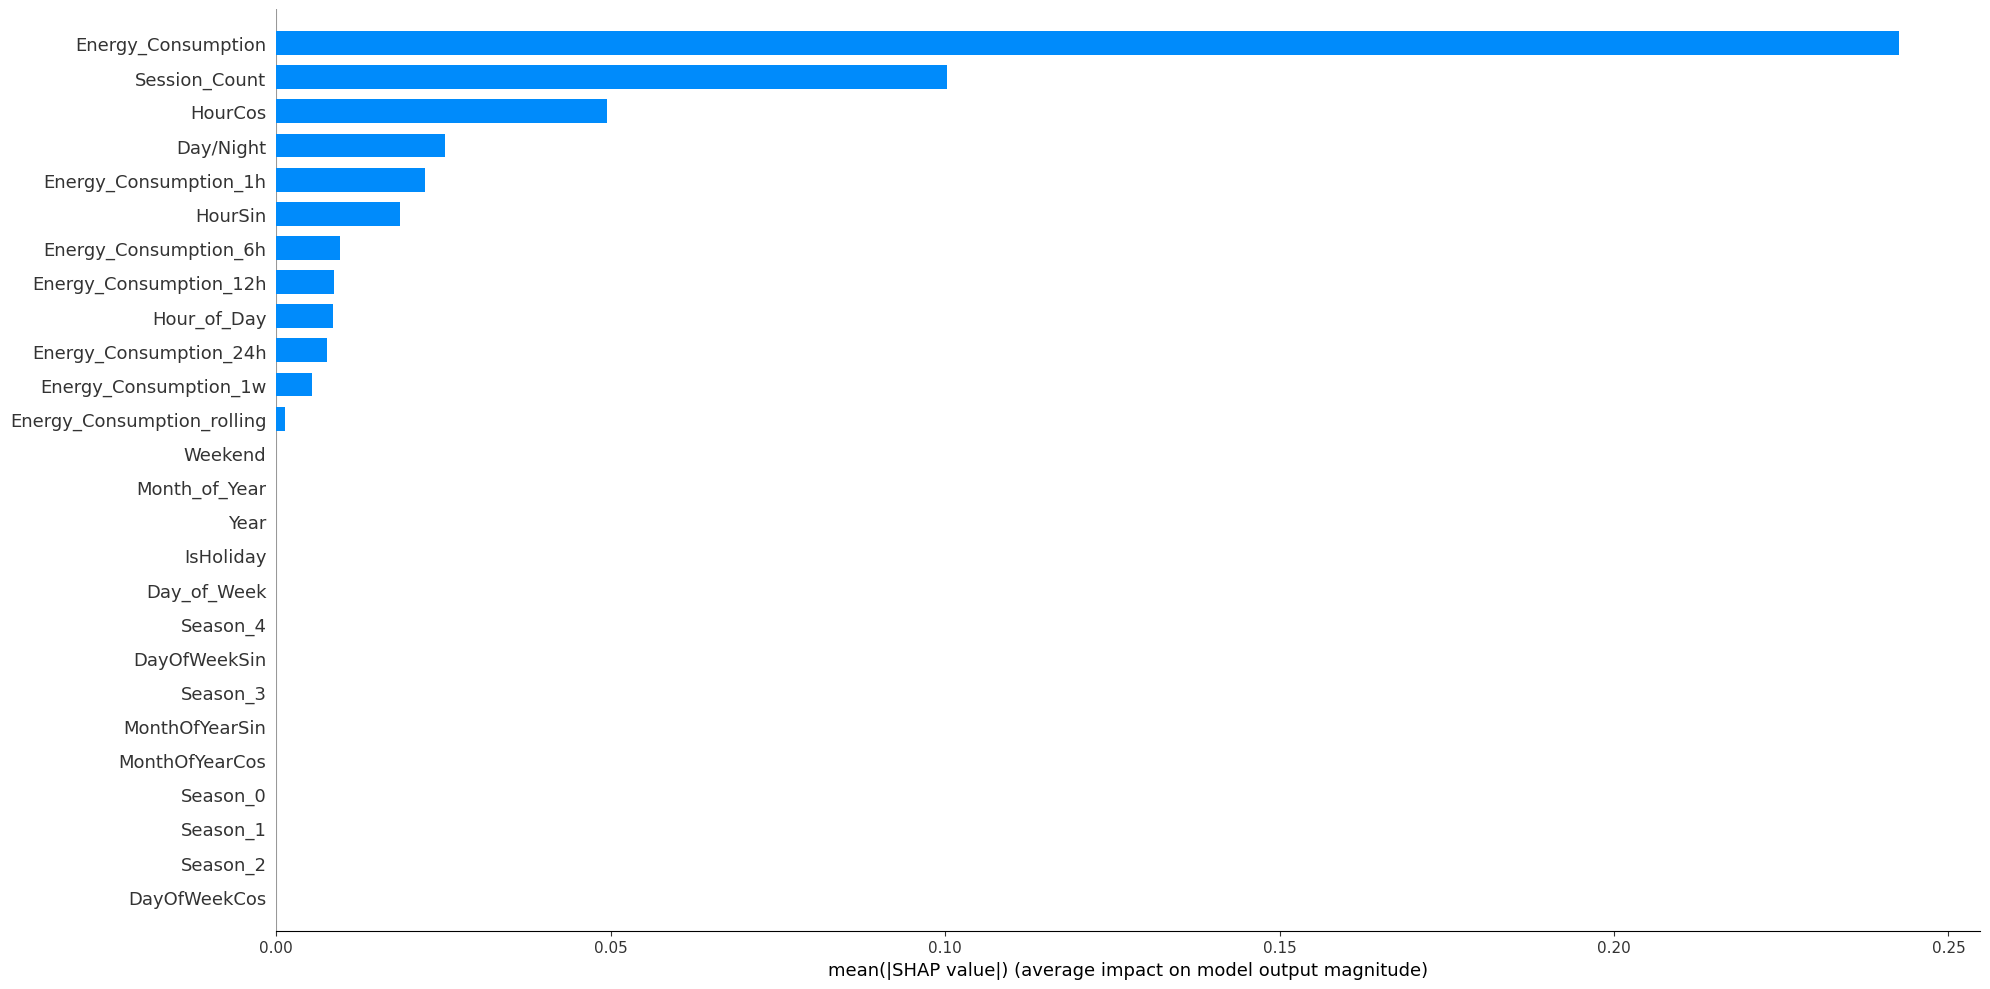

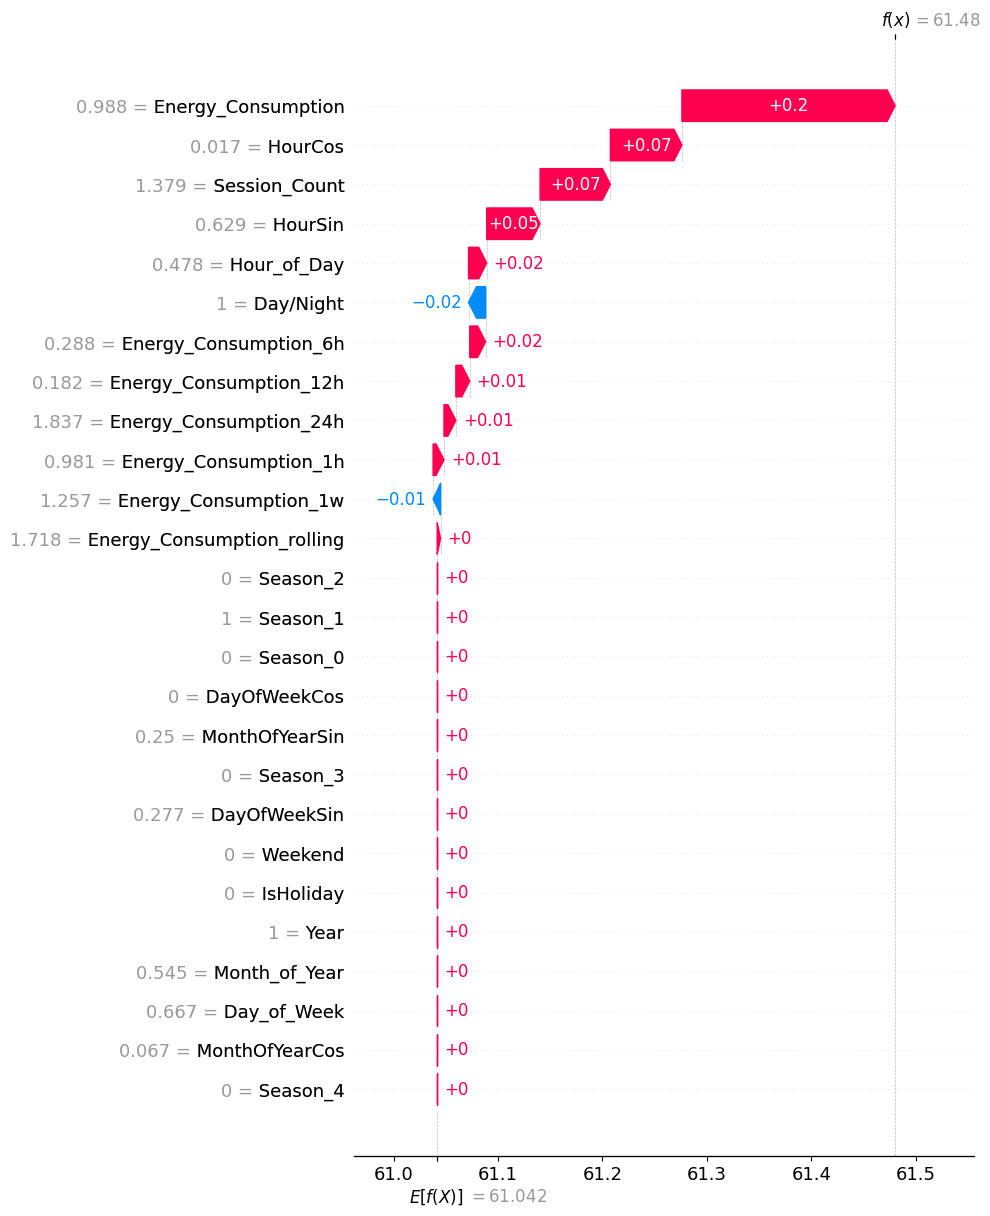

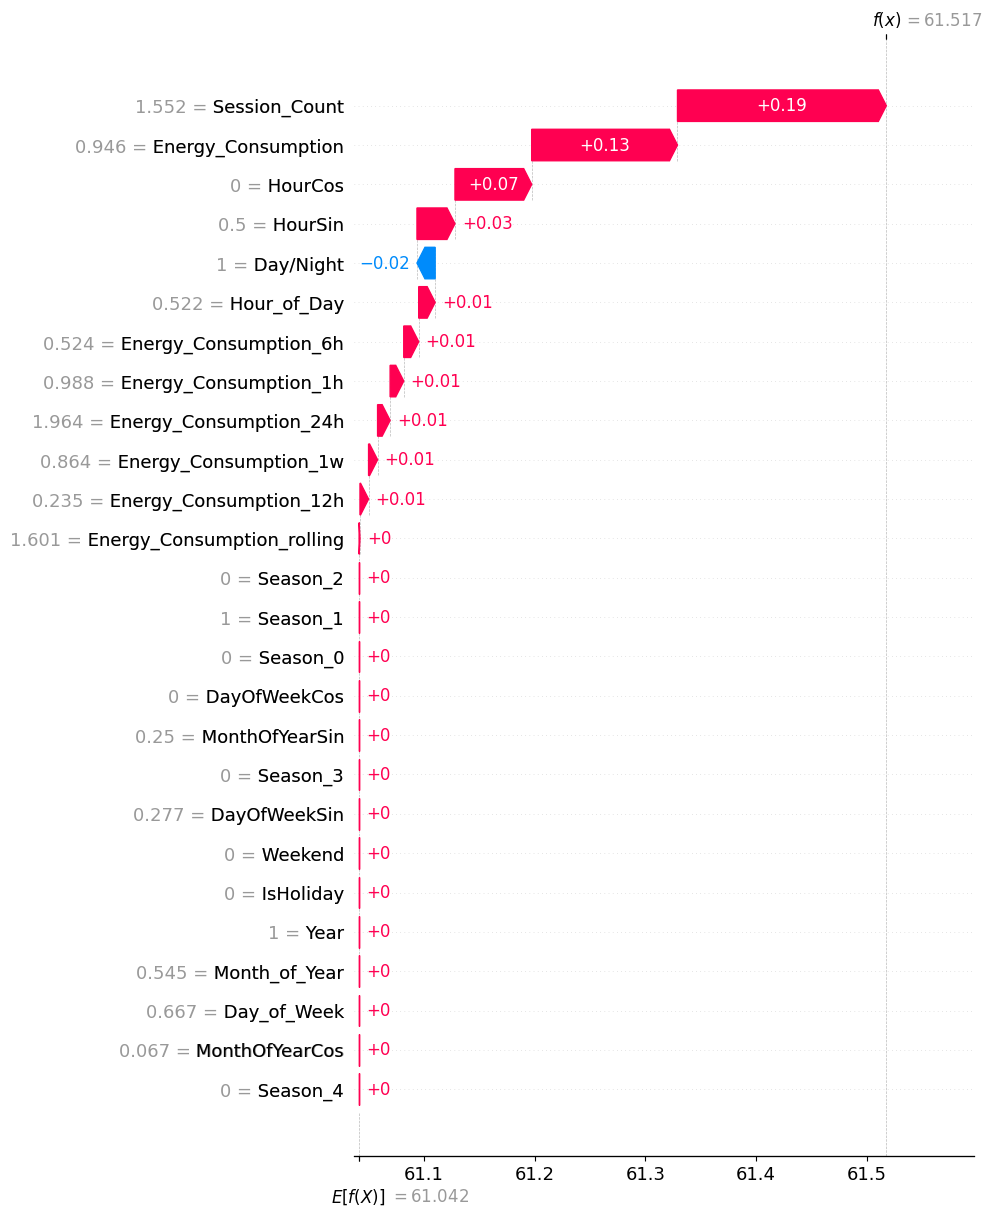

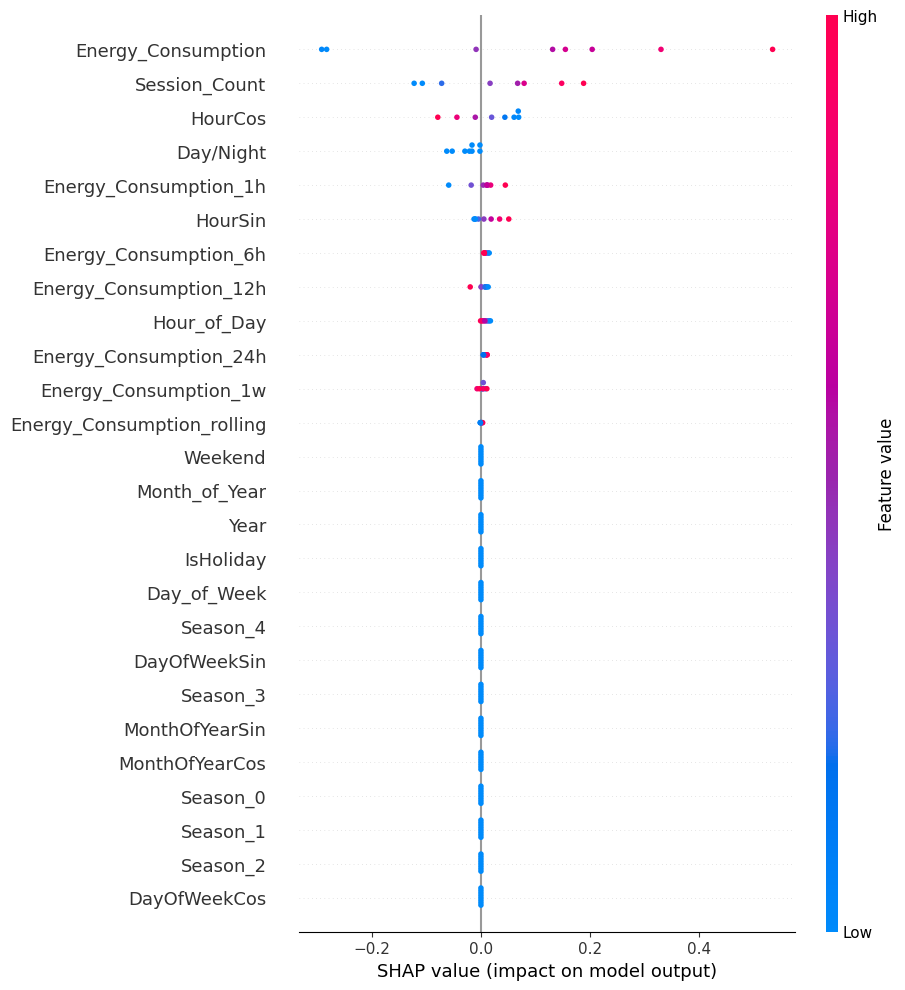

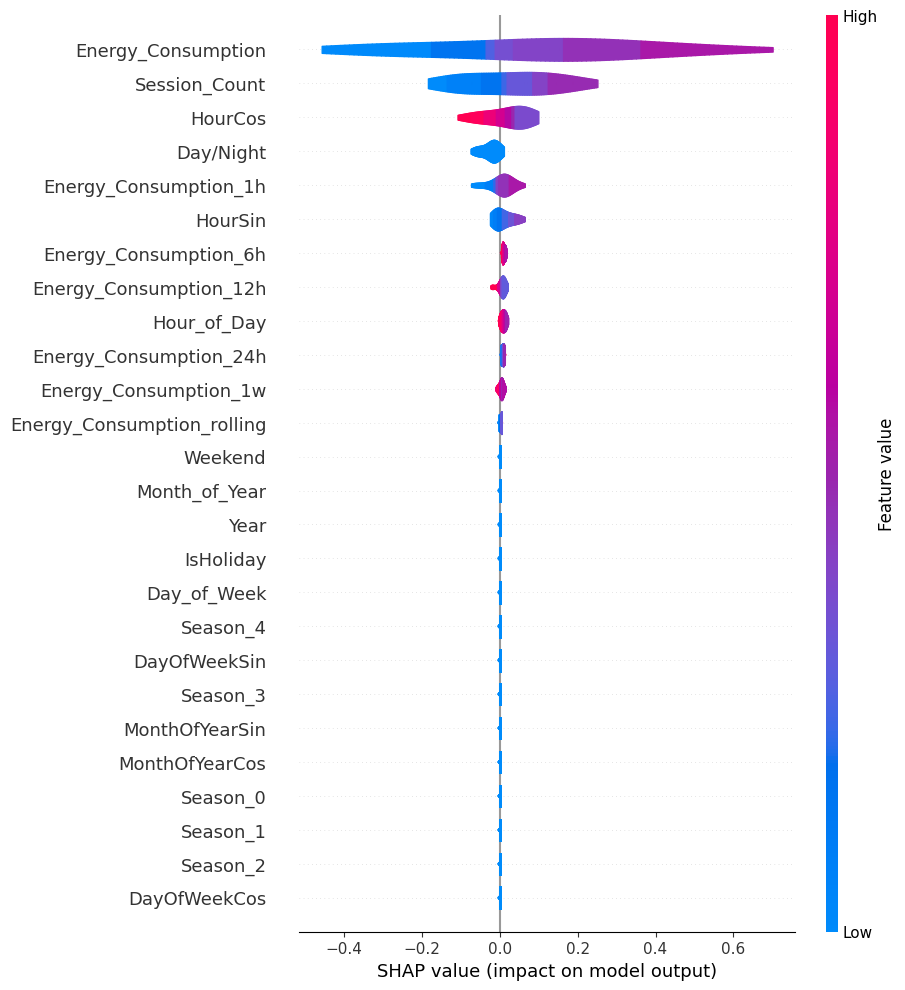

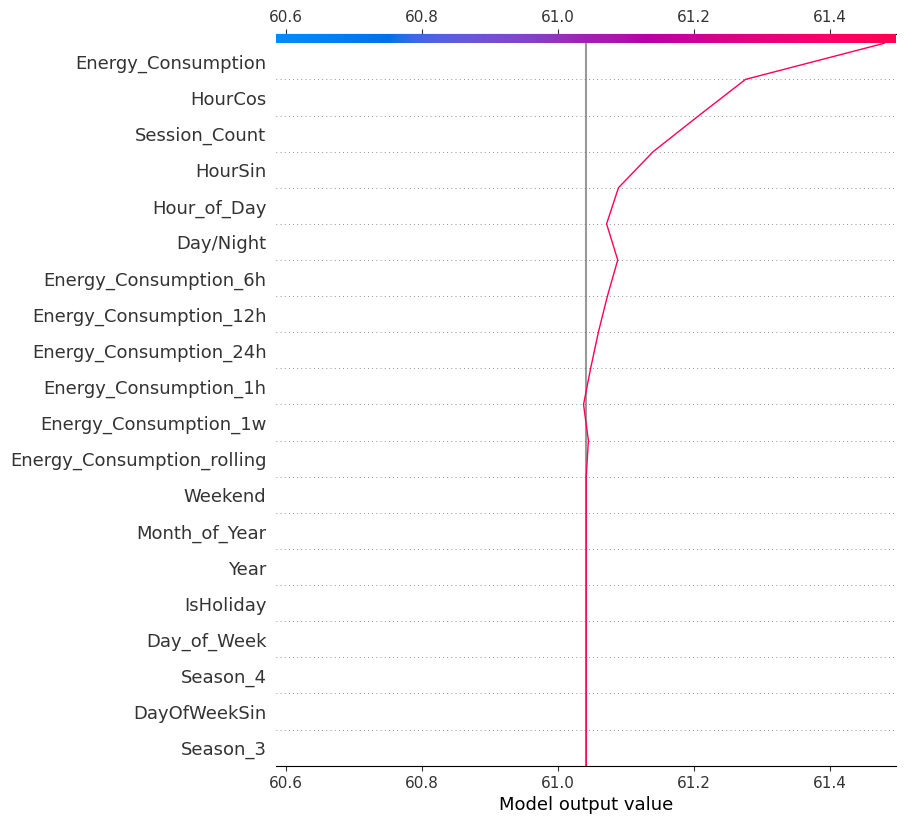

array([[ 2.04179317e-01,  6.73276847e-02,  0.00000000e+00,
         1.74352359e-02,  0.00000000e+00,  0.00000000e+00,
        -1.63601631e-02,  0.00000000e+00,  0.00000000e+00,
         5.11089415e-02,  6.84973125e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.04389098e-02,  1.51876827e-02,  1.32964368e-02,
         1.13681380e-02, -7.13416581e-03,  3.19661604e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.31557710e-01,  1.88433493e-01,  0.00000000e+00,
         1.48539816e-02,  0.00000000e+00,  0.00000000e+00,
        -1.64121003e-02,  0.00000000e+00,  0.00000000e+00,
         3.42906421e-02,  6.92230312e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.22922664e-02,  1.34942455e-02,  7.75365596e-03,
         1.13095135e-02,  8.12728418e-03,  7.80672949e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00

In [76]:
def compute_shap_values_using_deep_explainer(model, dataloader, feature_names, agg_func=np.mean):
  ## Compute SHAP values ## 
  model.eval()  # Ensure the model is in evaluation mode
  X, _ = next(iter(dataloader))
  batch_size, seq_len, input_size = X.shape

  # Create a DeepExplainer object
  explainer = shap.DeepExplainer(model, X)

  # Compute SHAP values
  shap_values = explainer.shap_values(X, check_additivity=False)

  shap_values_agg = agg_func(shap_values.reshape(batch_size, seq_len, input_size), axis=1)  # (batch_size, input_size)
  
  shap.summary_plot(
    shap_values=shap_values_agg, 
    features=X[:, -1, :].numpy(),
    feature_names=feature_names,
    plot_type='bar',
    show=False,
    max_display=26,
    plot_size=(20, 10)
  )
  plt.savefig('shap_summary_plot_deep_explainer.png', bbox_inches='tight', dpi=700)
  plt.show()

  # Waterfall plot for the first sample
  shap.waterfall_plot(shap.Explanation(values=shap_values_agg[0], base_values=explainer.expected_value, data=X[0, -1, :].numpy(), feature_names=feature_names), show=False, max_display=26)
  plt.savefig('shap_waterfall_plot_deep_explainer.png', dpi=700, bbox_inches='tight')
  plt.show()

  # Waterfall plot for the second sample
  shap.waterfall_plot(shap.Explanation(values=shap_values_agg[1], base_values=explainer.expected_value,
                      data=X[1, -1, :].numpy(), feature_names=feature_names), show=False, max_display=26)
  plt.savefig('shap_waterfall_plot_deep_explainer_100.png', dpi=700, bbox_inches='tight')
  plt.show()

  # Beeswarm plot 
  shap_values_explanation = shap.Explanation(values=shap_values_agg, base_values=explainer.expected_value, data=X[:, -1, :].numpy(), feature_names=feature_names)
  shap.plots.beeswarm(shap_values_explanation, max_display=26, show=False)
  plt.show()

  # Violin plot
  shap.plots.violin(shap_values_explanation, max_display=26, show=False) 
  plt.show()

  # Shap scatter plot
  shap.decision_plot(explainer.expected_value, shap_values_agg[0], feature_names=feature_names, show=False)
  plt.show()

  # Save the SHAP values to a CSV file
  shap_values_df = pd.DataFrame(shap_values_agg, columns=feature_names)
  shap_values_df.to_csv('shap_values_deep_explainer.csv', index=False)

  return shap_values_agg


compute_shap_values_using_deep_explainer(model, colmod.predict_dataloader(), feature_names, agg_func=np.mean)

## Unit test of Datamodel and Dataloader

In [74]:
def test_data_module(): 
  dm = ColoradoDataModule(
    data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv', 
    scaler=MinMaxScaler(), 
    seq_len=12, 
    batch_size=8, 
    num_workers=0, 
    is_persistent=False
  )

  dm.setup(stage='fit')
  train_loader = dm.train_dataloader()
  batch = next(iter(train_loader))
  x, y = batch
  print(f"x shape: {x.shape}, y shape: {y.shape}")

def unit_test_dataloader_shapes(): 
  dm = ColoradoDataModule(
    data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv',
    scaler=MinMaxScaler(),
    seq_len=12,
    batch_size=8,
    num_workers=0,
    is_persistent=False
  )

  dm.setup(stage='fit')
  for x, y in dm.train_dataloader(): 
    assert x.ndim == 3, "Expected x to be 3D (batch, sequence, features)"
    assert y.ndim == 2, "Expected y to be 2D (batch, target)"

    assert x.shape[0] == dm.batch_size, f"Expected batch size to be {x.shape[0]}"
    assert x.shape[1] == 12, f"Expected sequence length 12, got {x.shape[1]}"
    assert x.shape[2] == 26, f"Expected 26 features, got {x.shape[2]}"
    print("Batch shapes are as expected!")
    break 

def end_to_end_testing():
  model = LSTM(input_size=26, hidden_size=100, num_layers=1,
               criterion=nn.MSELoss(), dropout=0.2, learning_rate=0.001)

  dm = ColoradoDataModule(
      data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv',
      scaler=MinMaxScaler(),
      seq_len=12,
      batch_size=8,
      num_workers=7,
      is_persistent=True
  )

  dm.setup(stage='fit')
  trainer = L.Trainer(max_epochs=10, logger=False)
  trainer.fit(model, dm)
  trainer.test(model, dm)
  trainer.predict(model, dm)

test_data_module()
unit_test_dataloader_shapes()
# end_to_end_testing()

x shape: torch.Size([8, 12, 26]), y shape: torch.Size([8, 1])
Batch shapes are as expected!


## Tensorboard

In [75]:
%reload_ext tensorboard
%tensorboard --logdir=Models/lightning_logs/

Reusing TensorBoard on port 6006 (pid 32153), started 2:05:35 ago. (Use '!kill 32153' to kill it.)